In [1]:
from collections import defaultdict, OrderedDict
from functools import reduce
from itertools import chain, cycle, islice

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import smartsheet

from portfolio import CashFlow, combine_flows, debug_row, PortfolioSheetRow
from utils import colorscale, get_smartsheet_cell, SmartsheetRow

# Portfolio Cash Flow Analysis

In [2]:
# Define a quartely time schema
years_in_model = 3
periods_in_year = 4
# TODO: rename to "periods_1_12"
quarters = list(range(1, years_in_model * periods_in_year + 1))  # list bc we don't want this to be a generator
# TODO: rename to "periods_0_11"
quarters_index = list(range(years_in_model * periods_in_year))
quarter_labels = ['Q' + str(q) for q in quarters]

# smartsheet
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

COST_BASELINE = get_smartsheet_cell(18, 2, sheet, 'value') / periods_in_year
COST_VARIABLE = get_smartsheet_cell(19, 2, sheet, 'value') / periods_in_year
# debug_row(38, sheet)

In [3]:
# Allow for easy targeting of rows, here [20 - 70]
SHEET_ROW_START = 30
SHEET_ROW_END = 70

def sheet_row_to_cf(row):
    return CashFlow(
        delay_qtrs = row.delay_qtrs,
        digital_gallons = row.digital_gallons,
        discount_rate = row.discount_rate,
        max_amt = row.max_amt,
        scale_up_qtrs = row.scale_up_qtrs,
        function = row.function,
        name = row.name,
        is_cost = row.is_cost,
        start_amt=row.start_value,
    )

# iterate through smartsheet and build project map, then sort it
project_map = defaultdict(list)
for index, sheet_row in enumerate(sheet.rows):
    if index < SHEET_ROW_START or index > SHEET_ROW_END:
        continue

    row = PortfolioSheetRow(sheet_row.to_dict())
    if row.project_code and row.include_in_model:
        project_map[row.project_code].append(sheet_row_to_cf(row))
project_map = OrderedDict(sorted(project_map.items()))  # sort ordered dictionary by keys

In [4]:
# Build Cash Flow DataFrame from project_map
rows = []
for project_id, cash_flows in project_map.items():
    for cash_flow in cash_flows:
        rows.append([project_id, True, cash_flow.name] + cash_flow.discounted_qtr)  # Discounted
        rows.append([project_id, False, cash_flow.name] + cash_flow.non_discounted_qtr)  # Undiscounted
        
cf_df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
summarized_df = cf_df.groupby(['project', 'discounted'])\
                  .sum(numeric_only=True)\
                  .sum(numeric_only=True, axis=1)\
                  .reset_index(name='NPV')\
                  .sort_values(by=['project'])

# Create a dataframe with variable cost
rows = []
for project_id, flows in project_map.items():
    unit_multiplier = 10**6  # put in dollars
    dg_to_variable_cost = lambda v: v * unit_multiplier * COST_VARIABLE

    for cf in flows:
        d_dg_cost = list(map(dg_to_variable_cost, cf.discounted_dg_qtr))
        nd_dg_cost = list(map(dg_to_variable_cost, cf.non_discounted_dg_qtr))
        d_variable_cost = [0]  # No variable cost at Q0
        nd_variable_cost = [0]  # No variable cost at Q0
        # iterable is of form [(0, (0, 1)), (1, (1, 2)), (n, (n + 1))]
        for index, step in list(enumerate(zip(quarters_index, quarters)))[:-1]:  
            # integraing using trapezoidal riemann sum
            d_variable_cost.append(np.trapz([d_dg_cost[index], d_dg_cost[index + 1]], step))
            nd_variable_cost.append(np.trapz([nd_dg_cost[index], nd_dg_cost[index + 1]], step))
    
        rows.append([project_id, True, cf.name] + d_variable_cost)
        rows.append([project_id, False, cf.name] + nd_variable_cost)
    
dg_df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
summarized_dg_df = dg_df.groupby(['project', 'discounted'])\
                      .sum(numeric_only=True)\
                      .sum(numeric_only=True, axis=1)\
                      .reset_index(name='Variable Cost ($)')\
                      .sort_values(by=['project'])

# Merge the two together
summarized = pd.merge(summarized_df, summarized_dg_df, how='inner', on=['project', 'discounted'])
summarized

,project,discounted,NPV,Variable Cost ($)
0,BP,False,15.180000,181250.000000
1,BP,True,14.736644,139139.993237
2,FS,False,27.711534,419815.366337
3,FS,True,21.843498,255645.727485
4,PV,False,22.225145,261891.517677
5,PV,True,13.297180,123407.070467


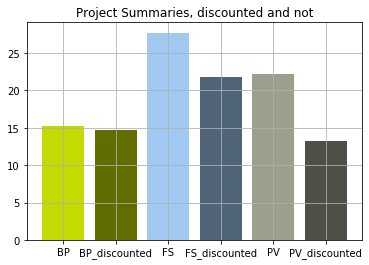

In [5]:
def gen_label(row):
    postfix = '_discounted' if row['discounted'] else ''
    return row['project'] + postfix

table = cf_df.groupby(['project', 'discounted'])\
          .sum(numeric_only=True)\
          .sum(numeric_only=True, axis=1)\
          .reset_index(name='NPV')\
          .sort_values(by=['project'])

table['label'] = table.apply(gen_label, axis=1)
table


# This is way overly complex, but was fun to write
colors = ["#2D0028", "#C5DA00", "#A0C8F0", "#9BA08C"]
colors_cycled = list(islice(
    cycle(colors[1:]),     # generator of infinitely repeated colors
    0,                 # start at the beginning
    len(project_map)), # we're going to zip later & 2x the proj num is # of bars
) 
darkened_colors = map(lambda color: colorscale(color, .5), colors_cycled)
bar_colors = list(chain.from_iterable(zip(colors_cycled, darkened_colors)))

# TODO: Add colors to bars based on project code beign in the x-axis label
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(table['label'], table['NPV'], color=bar_colors)
ax.set_title('Project Summaries, discounted and not')
ax.grid(True)

In [6]:
def display_dataframe(df, title):
    display(HTML(f'<div><h3>{title}</h3></div>'))
    df.loc["Total"] = df.sum(numeric_only=True)
    cleaned = df.drop(['project', 'discounted'], axis=1)
    display(cleaned)

    
for project_id in cf_df['project'].unique():
    display(HTML(f'<div><h1>{project_id}</h1><hr /></div>'))
    ndf = cf_df[cf_df['project'] == project_id].set_index('name')
    display_dataframe(ndf[ndf['discounted']].copy(), "Discounted Cash Flows")
    display_dataframe(ndf[ndf['discounted'] == False].copy(), "Undiscounted Cash Flows")

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,0.40,0.383740,0.368273,0.353570,0.339603,0.326345,0.313770,0.301852,0.290567,0.279891,0.269800,0.260273
Internal Headcount,0.00,0.014468,0.028583,0.042354,0.055788,0.068896,0.081683,0.094159,0.106330,0.118204,0.129789,0.141091
Revenue Defense - Showme,0.40,0.392771,0.385803,0.379088,0.372615,0.366376,0.360362,0.354566,0.348979,0.343594,0.338404,0.333402
United Ethanol Whitespace Win,0.24,0.235663,0.231482,0.227453,0.223569,0.219825,0.216217,0.212739,0.209387,0.206157,0.203042,0.200041
Guardian - Hankinson Defense,0.00,0.000000,0.000000,0.000000,0.000000,0.347702,0.339013,0.330836,0.323140,0.315896,0.309079,0.302662
Valero - Net new,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233932
Madeira - Fleet Trials,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157948,0.154539,0.151331
Total,1.04,1.026641,1.014141,1.002464,0.991575,1.329143,1.311046,1.294152,1.278403,1.421690,1.404654,1.622733


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,0.40,0.383333,0.366667,0.35,0.333333,0.316667,0.30,0.283333,0.266667,0.25,0.233333,0.216667
Internal Headcount,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
Revenue Defense - Showme,0.40,0.400000,0.400000,0.40,0.400000,0.400000,0.40,0.400000,0.400000,0.40,0.400000,0.400000
United Ethanol Whitespace Win,0.24,0.240000,0.240000,0.24,0.240000,0.240000,0.24,0.240000,0.240000,0.24,0.240000,0.240000
Guardian - Hankinson Defense,0.00,0.000000,0.000000,0.00,0.000000,0.400000,0.40,0.400000,0.400000,0.40,0.400000,0.400000
Valero - Net new,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.400000
Madeira - Fleet Trials,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.20,0.200000,0.200000
Total,1.04,1.023333,1.006667,0.99,0.973333,1.356667,1.34,1.323333,1.306667,1.49,1.473333,1.856667


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,0.0,0.007622,0.015058,0.022313,0.029390,0.036296,0.043032,0.049605,0.056017,0.062272,0.068375,0.074330
Pipeline FS Product Credits,0.0,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Pipeline FS - Stockton,0.0,0.000000,0.000000,0.000000,0.302942,0.291766,0.281605,0.272368,0.263971,0.256338,0.249398,0.243089
Pipeline FS - Magic Valley,0.0,0.000000,0.316106,0.298353,0.282916,0.269492,0.257819,0.247669,0.238842,0.231167,0.224493,0.218690
Projected Offensive Wins,0.0,0.000000,0.000000,1.061494,1.181440,1.310149,1.441035,1.566022,1.676971,1.767315,1.833239,1.873996
Projected Defensive Wins,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.123130,0.136082,0.149980,0.164113,0.177609,0.189589
Total,0.0,0.187622,0.511164,1.562160,1.976689,2.087702,2.326622,2.451745,2.565781,2.661205,2.733114,2.779694


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline FS Product Credits,0.0,0.18,0.18,0.18,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Pipeline FS - Stockton,0.0,0.00,0.00,0.00,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000
Pipeline FS - Magic Valley,0.0,0.00,0.36,0.36,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000,0.360000
Projected Offensive Wins,0.0,0.00,0.00,1.15,1.328295,1.533978,1.761077,2.000000,2.238923,2.466022,2.671705,2.850000
Projected Defensive Wins,0.0,0.00,0.00,0.00,0.000000,0.000000,0.143750,0.166037,0.191747,0.220135,0.250000,0.279865
Total,0.0,0.18,0.54,1.69,2.228295,2.433978,2.804827,3.066037,3.330670,3.586157,3.821705,4.029865


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,0.00,0.010851,0.021437,0.031765,0.041841,0.051672,0.061262,0.070619,0.079747,0.088653,0.097342,0.105819
Benefits - Contracted GPRE,0.75,0.727941,0.707180,0.687640,0.669249,0.651941,0.635650,0.620318,0.605887,0.592306,0.579523,0.567492
Benefits - Potential GPRE,0.00,0.000000,0.000000,0.158025,0.222410,0.307521,0.414211,0.537858,0.665971,0.779489,0.859559,0.896002
Total,0.75,0.738792,0.728617,0.877430,0.933501,1.011133,1.111123,1.228795,1.351605,1.460447,1.536423,1.569313


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,0.00,0.00,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
Benefits - Contracted GPRE,0.75,0.75,0.75,0.750,0.750000,0.750000,0.750000,0.750000,0.750000,0.75,0.750000,0.750000
Benefits - Potential GPRE,0.00,0.00,0.00,0.225,0.356258,0.554162,0.839725,1.226692,1.708737,2.25,2.791263,3.273308
Total,0.75,0.75,0.75,0.975,1.106258,1.304162,1.589725,1.976692,2.458737,3.00,3.541263,4.023308


In [7]:
class Project():
    """Add cash flows to a project"""
    def __init__(self, name, cash_flows=None):
        self.name = name
        self.cash_flows = cash_flows
        # Generate Graph portion
        self.graph_out = widgets.Output()
        self.update_graphs()
        # Generate Table portion
        self.table_out = widgets.Output()
        self.update_table()
        self.app = widgets.VBox(children=[self.graph_out, self.table_out], layout=widgets.Layout(overflow="hidden"))
        display(self.app)
    
    def to_df(self):
        df = pd.DataFrame(map(lambda cf: cf.to_json(), self.cash_flows)).drop(['flow_id'], axis=1)
        return df.set_index('name')
            
    def update_table(self):
        self.table_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return
        
        table = self.to_df()
        with self.table_out:
            display(table)
        
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]
        
        def get_max(flows):
            values = reduce(
                list.__add__,
                [list(map(
                    lambda v: abs(v),
                    flow.non_discounted_qtr + flow.discounted_qtr
                )) for flow in flows])
            maximum = max(values)
            return -1 * maximum, maximum
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 4
            rows = len(self.cash_flows) // cols + 1
            figsize = (12, rows * 3)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_max(self.cash_flows)
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.xaxis.set_ticks(range(1, 13))
                ax.axhline(y=0, color='black', linestyle='--')
                # TODO: should pull from "tot_qtrs" in some way
#                 linestyle_discounted = '-' if cf.discounted else '--'
#                 linestyle_non_discounted = '--' if cf.discounted else '-'
                ax.plot(quarters_index, cf.discounted_qtr, color='r', label='discounted')
                ax.plot(quarters_index, cf.non_discounted_qtr, label='non-discounted')
                ax.legend()
                
            plt.show(fig)

In [8]:
# Build UI from project_map
projects = []
for project_id, cash_flows in project_map.items():
    display(HTML(f'<div><h1>{project_id}</h1><br /><hr /></div>'))
    projects.append(Project(project_id, cash_flows))
    
projects.sort(key=lambda x: x.name)

In [9]:
graph_out = widgets.Output()

def get_x_ticks(index, bar_width, step=1):
    return [x - (bar_width * len(projects)) + (bar_width * index) for x in range(12)]

def plot_projects_summary(cf_attribute):
    projects_values = map(lambda p: combine_flows(p.cash_flows, cf_attribute), projects)
    projects_net = [sum(values) for values in zip(*projects_values)]

    figsize = (25, 8)
    plt.figure(figsize=figsize)
    plt.xticks(range(0, 12))
    bar_room = .75 # 75% of space will have a bar plotted on it
    bar_width = bar_room * 1 / (len(projects) + 1)  # + 1 in denominator to account for 'net'
    legend_parents = []
    for i, project in enumerate(projects):
        xseries = get_x_ticks(i, bar_width)
        plot = plt.bar(
            xseries,
            combine_flows(project.cash_flows, cf_attribute),
            width=bar_width,
            color=colors[i + 1]
        )
        legend_parents.append(plot)

    legend_parents = [p[0] for p in legend_parents]
    net_xseries = get_x_ticks(len(projects), bar_width)
    net_plot = plt.bar(quarter_labels, projects_net, color=colors[0], width=bar_width)

    legend_parents.append(net_plot[0])
    plt.legend((*legend_parents,), (*map(lambda p: p.name, projects), 'net'), loc='upper left')
    plt.show()
    
def plot_digital_gallons():
    fig, ax = plt.subplots(figsize=(8, 6))
    flows = [quarter_labels]  # first argument are x-labels in stackplots
    for project in projects:
        aggregated_dg_qtr = combine_flows(project.cash_flows, 'non_discounted_dg_qtr')
        flows.append(list(map(lambda x: x * 10**6, aggregated_dg_qtr)))
    plt.stackplot(
        *flows,
        labels=list(map(lambda p: p.name, projects)),
        colors=colors[1:]
    )
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.legend(loc='upper left')
    plt.title('Digital Gallon Contribution')
    plt.ylabel('Digital Gallons')
    plt.show()

def plot_program_cost():
    """Currently units plot in "millions". 
    
    multiplier  - 10**0 -> millions
                - 10**3 -> hundred thousands dollars
                - 10**6 -> dollars
    """
    unit_multiplier = 10**6
    fig, ax = plt.subplots(figsize=(8, 6))

    baseline_cost = [COST_BASELINE * unit_multiplier for quarter in quarters]
    dg_flows = [quarter_labels, baseline_cost]  # first argument are x-labels in stackplots
    project_keys = project_map.keys()

    agg_dg_df = dg_df.groupby(['project', 'discounted']).sum(numeric_only=True).reset_index()
    discounted_agg_dg_df= agg_dg_df[agg_dg_df['discounted']]
    for _, row in discounted_agg_dg_df.iterrows():
        dg_flows.append([getattr(row, label) for label in quarter_labels])
    
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.stackplot(
        *dg_flows,
        labels=['baseline cost'] + list(map(lambda p: p.name + ' variable cost', projects)),
        colors=colors
    )
    plt.legend(loc='upper left')
    plt.title('Discounted Program Cost')
    plt.show()

def graph_projects_cash_flow(_):
    graph_out.clear_output(wait=True)
    
    with graph_out:
        #  display(HTML('<h2>Program Cost</h2>'))
        plot_program_cost()
        
        #  disply(HTML('<h2>Digital Gallons by Project'))
        plot_digital_gallons()
        
        display(HTML('<h2>Discounted Cash Flows</h2>'))
        plot_projects_summary('discounted_qtr')
        
        display(HTML('<h2>Undiscounted Cash Flows</h2>'))
        plot_projects_summary('non_discounted_qtr')

with graph_out:
    graph_projects_cash_flow(None)

# button = widgets.Button(description='Refresh Chart')
# button.on_click(graph_projects_cash_flow)

chart = widgets.VBox(children=[graph_out])
chart

In [10]:
cf_df.sort_values(by=['discounted', 'project'], inplace=True)

In [11]:
import string
alphabet = string.ascii_uppercase
excel_columns_names = list(alphabet)
for letter1 in alphabet:
    for letter2 in alphabet:
        excel_columns_names.append(f'{letter1}{letter2}')

In [12]:
# This entire cell contains all of the code needed
# to build the excel sheet to be downloaded

def record_project(project, sheet, start_row, start_column=0):
    bold = workbook.add_format({'bold': True})
    row_num = start_row
    # Write the project name
    sheet.write(row_num, start_column, project.name)
    row_num += 1
    # write index then columns
    sheet.write(row_num, start_column, 'index', bold)
    for col_index, col in enumerate(project.to_df(), 1):  # start at 1 since index was written
        sheet.write(row_num, start_column + col_index, col, bold)
        
    for index, row in project.to_df().iterrows():
        row_num += 1
        sheet.write(row_num, start_column, index)
        for col_index, cell_value in enumerate(row, 1):
            sheet.write(row_num, start_column + col_index, cell_value)

writer = pd.ExcelWriter('./demo.xlsx', engine='xlsxwriter')
cf_df.to_excel(writer, sheet_name='output', index=False)

# calculate which cells hold the quarter values
num_quarters = len(quarters)
start_row = 2
end_row = start_row + len(cf_df) - 1
QUARTER_START_COLUMN = 3  # After 'project', 'discouted', and 'name'
start_quarter_columns = excel_columns_names[QUARTER_START_COLUMN]
end_quarter_columns = excel_columns_names[QUARTER_START_COLUMN + num_quarters]
quarter_cells = f'{start_quarter_columns}{start_row}:{end_quarter_columns}{end_row}'

# grab objects from pandas object
workbook  = writer.book
output_worksheet = writer.sheets['output']
projects_worksheet = workbook.add_worksheet('projects')

start_row = 0
for project in projects:
    record_project(project, projects_worksheet, start_row)
    start_row += len(project.cash_flows) + 3  # 3 for project name, header row, and a space

# create and apply formatting
float_format = workbook.add_format({'num_format': '##0.0000'})
## output sheet
output_worksheet.set_column(quarter_cells, None, float_format)
output_worksheet.set_column('C:C', 30)
output_worksheet.conditional_format(quarter_cells, {'type': '3_color_scale'})
## project sheet
projects_worksheet.set_column('A:A', 30)
projects_worksheet.set_column('B:H', 15)

writer.save()

In [13]:
%%html
<style>
.dwnld {
    border: 1px solid black;
    border-radius: 4px;
    padding: 5px;
    text-decoration: none !important;
}
</style>
<a class="dwnld" href="./voila/static/demo.xlsx" download="demo.xlsx">Download Excel Sheet</a>

In [14]:
# Play instances
cf = CashFlow(
    delay_qtrs=2, digital_gallons=100, discount_rate=.1, function='sigmoid',
    is_cost=False, start_amt=1, max_amt=5, scale_up_qtrs=4, tot_qtrs=12, name='test'
)

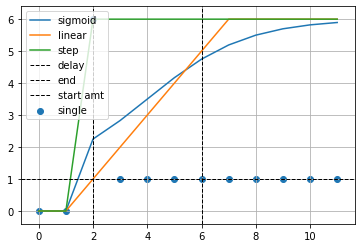

In [15]:
cf.quick_view(discounted=False)